# Train a recurrent neural network to predict the position of the mouse in the v0,v1 coordinate system.

We train a model for each recording session.

We get the animal position in the v0,v1 coordinate system from `transform_xy_to_grid_representation()`.

We get the instantaneous firing rate of all our grid cells. 

We need to remove time-points with invalid values as the model can't deal with np.nan.


### Rate normalization

The firing rate of neuron is normalize for two reasons: all neurons have a similar contribution and values around 0 should facilitate learning. For each neuron, the rate vector is transform so that its mean is 0 and STD is 1. 

When doing inference, we will use the same transformation as during training to normalize the firing rate. This is because we often have a very poor estimate of the firing rate from short streches of data used for inference.

### v0,v1 as model labels

Each component of v0,v1 coordinate is periodic (circular data). To facilite learning, We decompose $v_{i}$ into $cos(v_{i})$ and $sin(v_{i})$. This way the values will range from -1 to 1 and the jumps from 360 to 0 degrees are avoided. You can think of $v_{i}$ as a circle with a radius of 1.

### Trained model

The trained model is saved in `session_name.grid_cell_rnn_model.pt` in each session directory.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from scipy.stats import wilcoxon, pearsonr
from scipy.signal import find_peaks
import torch
import numpy as np
import datetime

from functions import *

# Break down of what goes into the model

<li>Input: Firing rate of many different grid cells as a function of time, split into sequences of 20 consequetive spike trains</li>
<li>Label: Location of the animal at that time point in toroidal coordinates</li>
<li>We first generate the training dataset, which uses animal position in the first random foraging</li>

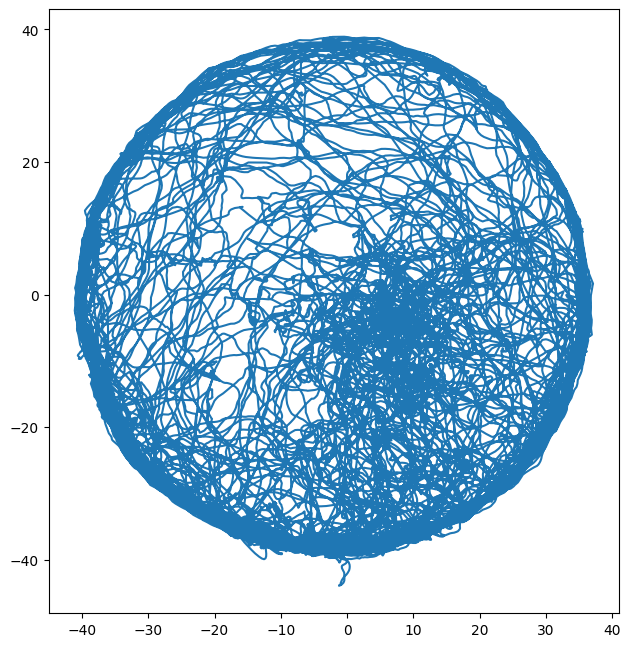

In [2]:
# Visualization of the first RF
ap = Animal_pose()
ap.load_pose_from_file(file_name=firstRF)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(ap.pose[:,1],ap.pose[:,2])
ax.set_aspect('equal') 

In [3]:
# Generate the simultaneously created grid cells
grid_param = {}
grid_param["n_cells"] = 25
grid_param["orientation"] = np.array([0,np.pi/3,np.pi/3*2])
grid_spacing = 35
grid_param["period"] = np.array([grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6)])
grid_param["offset"] = np.random.rand(grid_param["n_cells"],2)*grid_param["period"][0]
peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"] )
peak_rates[peak_rates<5] = 5
grid_param["peak_rate"] = peak_rates

neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=ap)  for i in tqdm(range(grid_param["n_cells"]))]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


In [4]:
for n in neuron_list:
    n.spatial_properties.firing_rate_map_2d()

In [5]:
train_pose = np.stack([ap.pose[:,0],ap.pose[:,1],ap.pose[:,2],ap.pose[:,4]]).T # only consider the data that we will be using
train_pose.shape

(87407, 4)

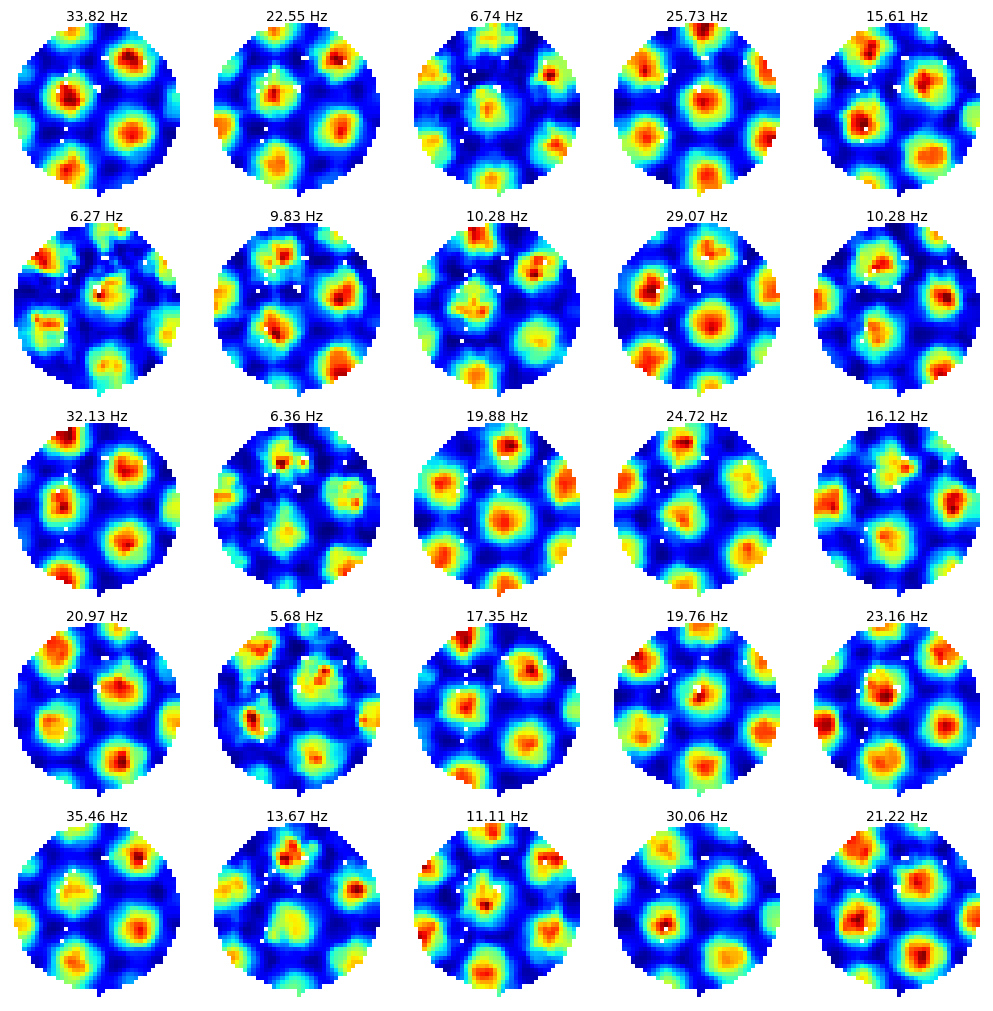

In [6]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))

In [7]:
# Get the grid cell IFR during training
ifrList = []
for i, n in tqdm(enumerate(neuron_list)):

    n.spike_train.instantaneous_firing_rate(bin_size_sec=0.02,sigma=2,shift_start_time =0.01)
    ifrList.append(n.spike_train.ifr[0])    
    if(i == 0):
        time = n.spike_train.ifr[2]
    n.spike_train.ifr=None # remove the reference to the numpy array, which can be deleted by garbage collector

ifr,time = (np.stack(ifrList,axis=0),time.round(4)) # added the round so that the numbers are not 0.019999999 but 0.02
train_ifr = ifr.T
train_time = time

0it [00:00, ?it/s]

25it [00:00, 298.66it/s]


Text(0, 0.5, 'Grid cells')

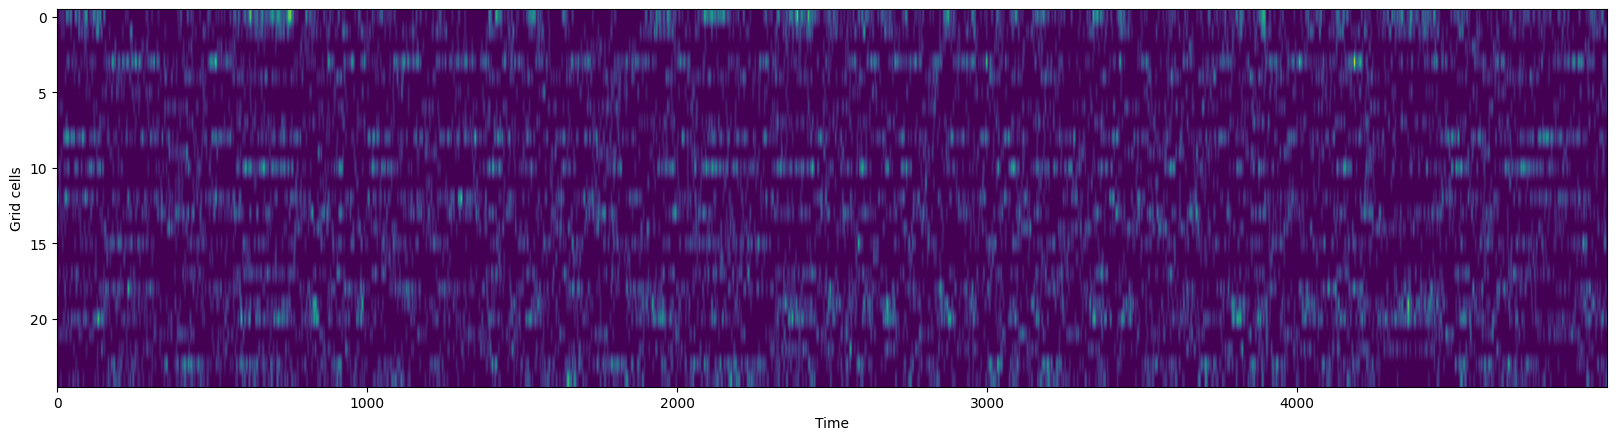

In [8]:
# Visualize the spike_train
fig, ax =plt.subplots(figsize=(20,5))
ax.imshow(train_ifr[:5000,:].T,aspect="auto",interpolation=None)
ax.set_xlabel('Time')
ax.set_ylabel('Grid cells')


In [9]:
train_ifr.shape,train_time.shape,train_pose.shape

((87407, 25), (87407,), (87407, 4))

<li>Training is performed in the first random foraging, using 80% percent of data for training and 20% for testing.</li> <br>
<li>For the validation cohort, we use the second random foraging position data.</li>

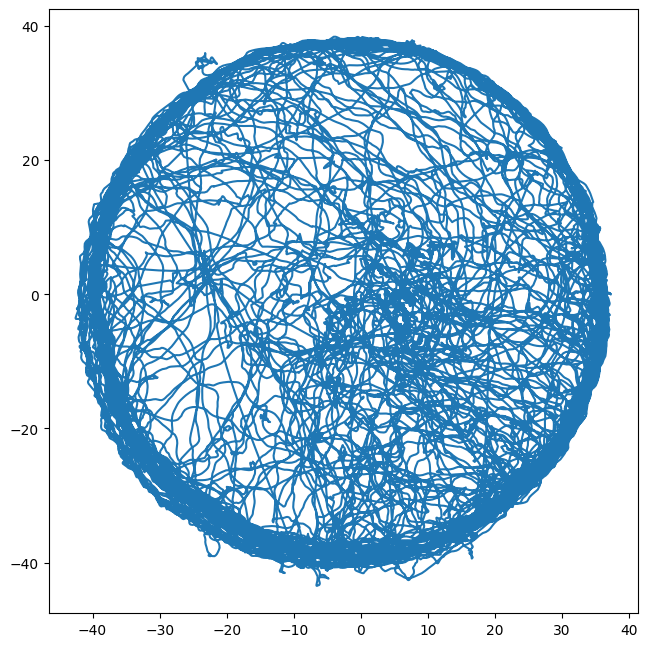

In [10]:
# Visualize animal position in the last random foraging
lap = Animal_pose()
lap.load_pose_from_file(file_name=lastRF)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(lap.pose[:,1],lap.pose[:,2])
ax.set_aspect('equal') 

In [11]:
# Generate the test neuron list using simulated grid cells
# This neuron list uses position data from the second random foraging data

test_neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=lap)  for i in tqdm(range(grid_param["n_cells"]))]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


In [12]:
for n in test_neuron_list:
    n.spatial_properties.firing_rate_map_2d()

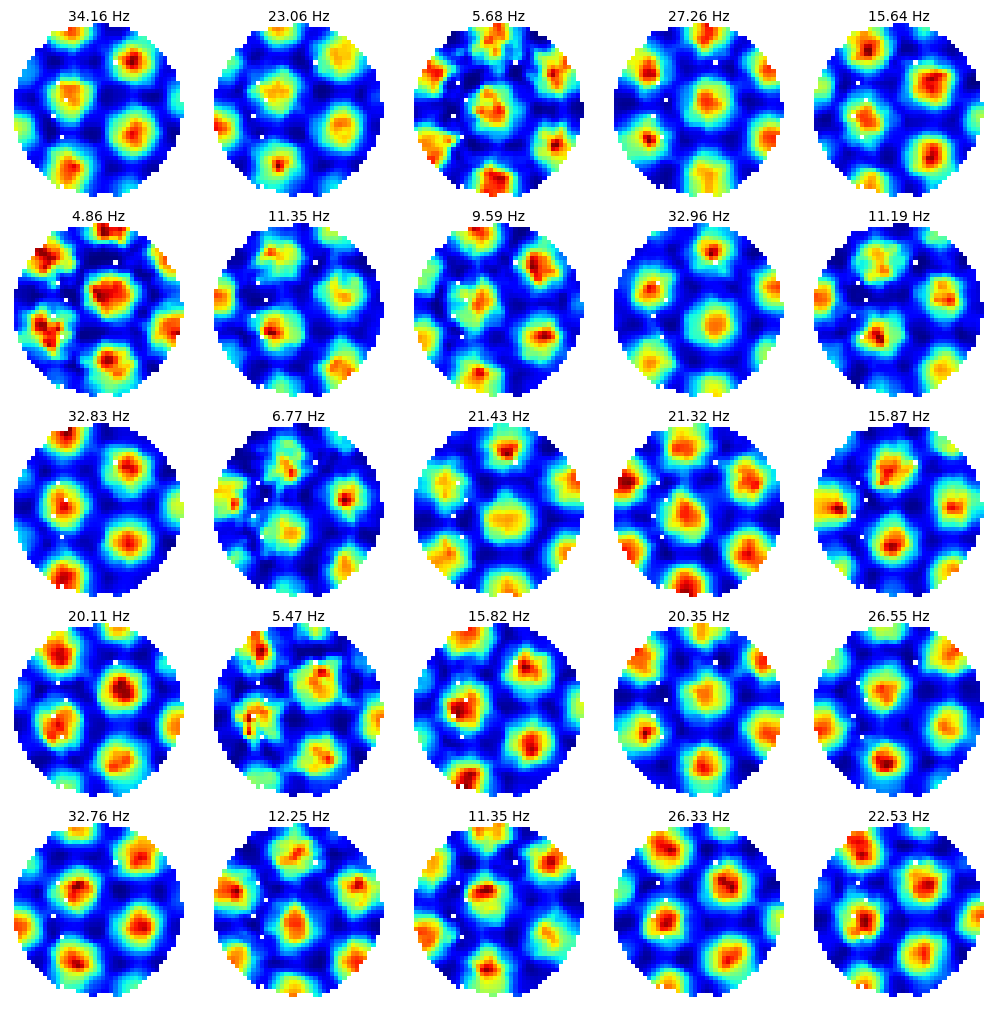

In [13]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(test_neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))

In [14]:
test_pose = np.stack([lap.pose[:,0],lap.pose[:,1],lap.pose[:,2],lap.pose[:,4]]).T # only consider the data that we will be using
test_pose.shape

(87750, 4)

In [15]:
ifrList = []
for i, n in tqdm(enumerate(test_neuron_list)):

    n.spike_train.instantaneous_firing_rate(bin_size_sec=0.02,sigma=2,shift_start_time =0.01)
    ifrList.append(n.spike_train.ifr[0])    
    if(i == 0):
        time = n.spike_train.ifr[2]
    n.spike_train.ifr=None 

ifr,time = (np.stack(ifrList,axis=0),time.round(4)) # added the round so that the numbers are not 0.019999999 but 0.02
test_ifr = ifr.T
test_time = time

0it [00:00, ?it/s]

25it [00:00, 284.70it/s]


In [16]:
test_ifr.shape,time.shape,test_pose.shape

((87750, 25), (87750,), (87750, 4))

# Save the ifr, pose and grid parameters

In [17]:
if train_ifr.shape[0] != train_pose.shape[0]:
    print("Problem with the shape of ifr and pose")
    print(train_ifr.shape,train_pose.shape)
print(train_ifr.shape)

(87407, 25)


In [18]:
if test_ifr.shape[0] != test_pose.shape[0]:
    print("Problem with the shape of ifr and pose")
    print(test_ifr.shape,test_pose.shape)
print(test_ifr.shape)

(87750, 25)


In [19]:
fn = "../data/train_ifr.pkl"
pickle.dump((train_ifr,train_time),open(fn,"wb"))

fn = "../data/test_ifr.pkl"
pickle.dump((test_ifr,test_time),open(fn,"wb"))

In [20]:
train_pose.shape, test_pose.shape

((87407, 4), (87750, 4))

In [21]:
fn = "../data/train_pose.pkl"
pickle.dump(train_pose,open(fn,"wb"))

fn = "../data/test_pose.pkl"
pickle.dump(test_pose,open(fn,"wb"))

In [22]:
# The grid parameters will be inferred using function from Step 2

Firing rate maps used to find grid cell parameters


  0%|          | 0/25 [00:00<?, ?it/s]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-20, -36]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.070111914650674


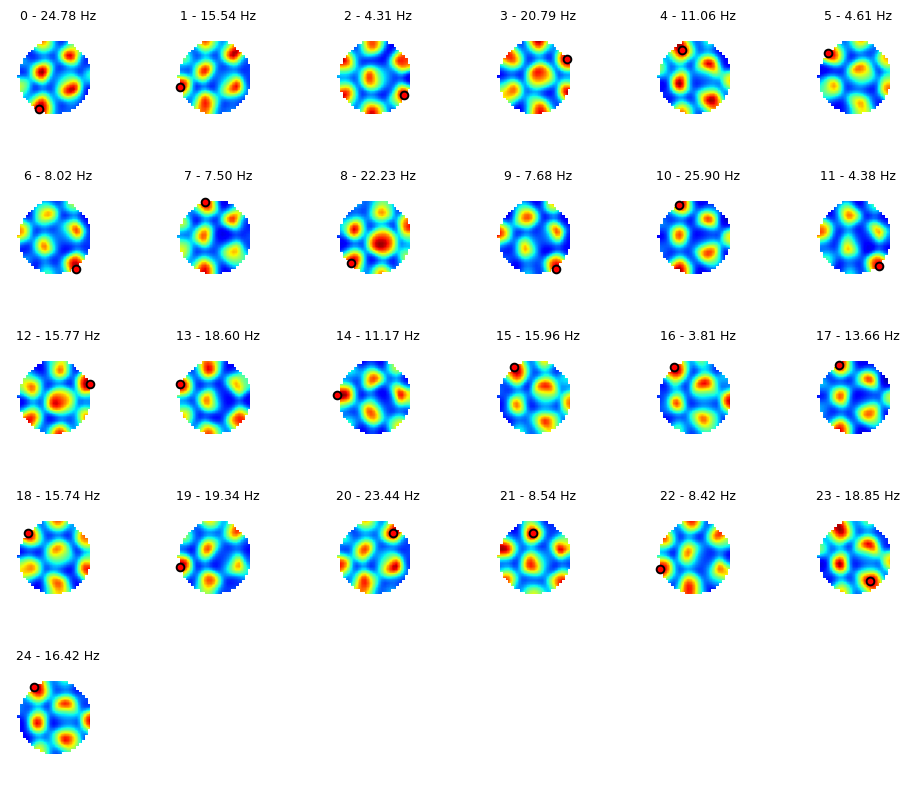

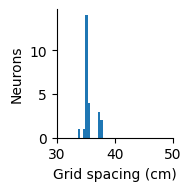

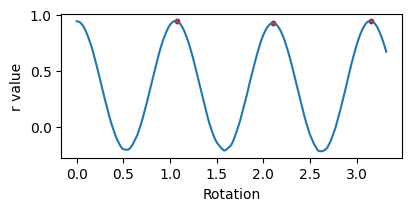

Visualize real and simulated grid pattern before fitting


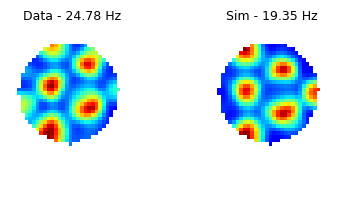

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 148.8644
Improvement of firing rate maps correlation after rigid fitting: from 0.630 to 0.976
Fitting more flexible grid cell model


In [23]:
find_grid_cell_parameters(neuron_list,save=True)

# Define and run the model

In [ ]:
def train_lstm(config,train_grid_coord, train_time, train_ifr, test_grid_coord, test_time,test_ifr, verbose=True):
    """
    This only takes the first 4 columns in train_grid_coord and test_grid_coord (v0, v1)
    """
    
    print(datetime.datetime.now(),config)
    
    train_dataset = NeuralDataset(ifr =train_ifr[:,:config["n_cells"]], pose=train_grid_coord[:,0:4], time=train_time,  seq_length=config["seq_length"])
    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds
    
    myDict = {"ifr_normalization_means": ifr_normalization_means,
              "ifr_normalization_stds": ifr_normalization_stds}
    
    # fn = sSes.fileBase+".rnn_ifr_normalization.pkl"
    # print("Saving:",fn)
    # with open(fn, 'wb') as handle:
    #     pickle.dump(myDict, handle)
    
    
    test_dataset = NeuralDataset(ifr =test_ifr[:,:config["n_cells"]], 
                             pose=test_grid_coord[:,0:4], 
                                 time= test_time,
                             seq_length=config["seq_length"],
                             ifr_normalization_means=ifr_normalization_means,
                             ifr_normalization_stds=ifr_normalization_stds)
    
    
    
    
    train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=config["batch_size"] , num_workers=2, shuffle=True, pin_memory=True) # to load batches
    test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=config["batch_size"] , num_workers=2, shuffle=False, pin_memory=False) # to load batches

    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)

    


    
    optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
    loss_fn = torch.nn.MSELoss() # 

    model.train()

    best_loss = float('inf')  # Initialize with a large value
    best_model_state = None

    df,best_model_state = training_loop(n_epochs=config["num_epochs"],
                 optimizer=optimizer,
                 model = model,
                 loss_fn = loss_fn,
                 train_data_loader=train_data_loader,
                 test_data_loader=test_data_loader,
                 config=config,
                 device = device,
                 verbose=True)
    return df, model,best_model_state

In [ ]:
train_ifr,train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time = load_position_ifr_dataset()

train_ifr.shape: (87407, 20)
train_pose.shape: (87407, 4)


In [ ]:
# HYPERPARAMETERS
config = {"seq_length":20,
            "n_cells":train_ifr.shape[1],
            "hidden_size" :256,
            "num_layers" : 2,
            "num_outputs" : 4, # sin and cos of v0 and v1
            "learning_rate" : 0.01,
            "batch_size" :64,
            "num_epochs": 100}

In [ ]:
df, model,best_model_state = train_lstm(config,
                                train_grid_coord,train_time,train_ifr,
                                test_grid_coord,test_time, test_ifr)

2024-03-25 10:55:41.762600 {'seq_length': 20, 'n_cells': 20, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 4, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 100}
Training starting at 2024-03-25 10:55:41.817440
Test loss without training: 0.5006598785226142
2024-03-25 10:55:51.753849 Epoch: 1/100, Training loss: 0.21526220956841813, Testing loss: 0.1462136164448889
2024-03-25 10:55:58.822344 Epoch: 2/100, Training loss: 0.13866570631743, Testing loss: 0.13785989684977296
2024-03-25 10:56:04.653873 Epoch: 3/100, Training loss: 0.1325025842586426, Testing loss: 0.13373176615079288
2024-03-25 10:56:10.738528 Epoch: 4/100, Training loss: 0.1287553855933871, Testing loss: 0.1311146465859041
2024-03-25 10:56:16.664396 Epoch: 5/100, Training loss: 0.12568474993502413, Testing loss: 0.1283009110302559
2024-03-25 10:56:22.674019 Epoch: 6/100, Training loss: 0.12294580106177581, Testing loss: 0.12585686166097568
2024-03-25 10:56:28.839209 Epoch: 7/100, Training loss: 0.1202841960439

In [ ]:
fn = "../data/grid_cell_model.pt"
print("saving the model state_dict to",fn)
torch.save(best_model_state, fn)

saving the model state_dict to ../data/grid_cell_model.pt
